### Lab Machine Learning, part one: Heart disease prediction.
[Link Kaggle dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)  
About the dataset:  
Features:  
- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code | 1 = woman, 2 = man
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
- All of the dataset values were collected at the moment of medical examination.

Purpose:
- Find the most important risk factors for cardiovascular disease. This means that "cardio" is the response variable and the other features are explanatory variables. This is a classification problem.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_orig = pd.read_csv('../data/cardio_train.csv', delimiter=";")

#### EDA

In [144]:
df_orig.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Examining the data, there is obviously some unrealistic data within it.
- Blood pressure: quite a lot of blood pressure metrics are unrealistic. Google search results in some knowledge on what values that are realistic to expect [Link to heart.org](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings)
- Weight: there is some unrealistically low wight observations. Hard to draw a line but questimation is that values below 40kg can be removed.
- Height: mesures below 120cm and above 220cm removed. Obviously it's possible to be both taller and smaller, but this seems reasonable.

In [145]:
# extracting "valid" data, based on above:
#df = df_orig[(df_orig['ap_lo'] < 200) & (df_orig['ap_lo'] > 40) & (df_orig['ap_hi'] > 50) & (df_orig['ap_hi'] < 220) & (df_orig['weight'] > 40) & (df_orig['height'] > 120) & (df_orig['height'] < 220)]
df = df_orig
print(f'Filtering removed {len(df_orig)-len(df)} instances of the sampled data')

Filtering removed 0 instances of the sampled data


1a: Number of individuals with presence and absence of cardiovascular disease.

In [146]:
cardio = df['cardio'].value_counts()
print(f'Nbr of individuels with absence of cardiovascular disease: {cardio.loc[0]}')
print(f'Nbr of individuels with presence of cardiovascular disease: {cardio.loc[1]}')

Nbr of individuels with absence of cardiovascular disease: 35021
Nbr of individuels with presence of cardiovascular disease: 34979


1b: Ratio of individuals with normal, above normal and well above normal cholesterol levels.

In [147]:
cholesterol_ratio = df['cholesterol'].value_counts()
cholesterol_ratio = cholesterol_ratio.to_frame()
cholesterol_ratio['cholesterol_ratio'] = cholesterol_ratio['count'] / cholesterol_ratio['count'].sum()
print(f'Ratio of individuals with "normal" cholesterol levels: {cholesterol_ratio.iloc[0,1]:.1%} percent')
print(f'Ratio of individuals with "above normal" cholesterol levels: {cholesterol_ratio.iloc[1,1]:.1%} percent')
print(f'Ratio of individuals with "well above normal" cholesterol levels: {cholesterol_ratio.iloc[2,1]:.1%} percent')


Ratio of individuals with "normal" cholesterol levels: 74.8% percent
Ratio of individuals with "above normal" cholesterol levels: 13.6% percent
Ratio of individuals with "well above normal" cholesterol levels: 11.5% percent


1c: Age distribution:

Age Data [years]: Mean=53.3, Stdev=6.8, Min=29.6, Max=65.0 


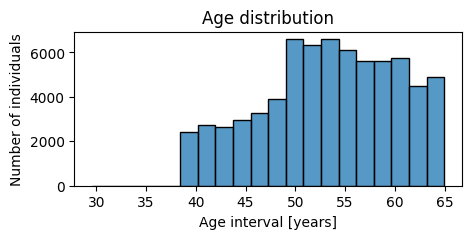

In [148]:
df.loc[:,'age_yrs'] = round(df.loc[:,'age']/365,2) # converting age in days into age in years
#df['age_yrs'] = round(df.loc[:,'age']/365,2) # converting age in days into age in years
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(data = df, x='age_yrs', bins=20), plt.title('Age distribution'), plt.ylabel('Number of individuals'), plt.xlabel('Age interval [years]')
print(f"Age Data [years]: Mean={df['age_yrs'].mean():.1f}, Stdev={df['age_yrs'].std():.1f}, Min={df['age_yrs'].min():.1f}, Max={df['age_yrs'].max():.1f} ")

1d: Ratio of smokers

In [149]:
ratio_smokers = df['smoke'][df['smoke'] == 1].sum() / len(df['smoke'])
print(f"Ratio of individuals that smoke: {ratio_smokers:.2%}")

Ratio of individuals that smoke: 8.81%


1e: Weight distribution.

Weight Data [kg]: Mean=74.21, Stdev=14.40, Min=10.00, Max=200.00 


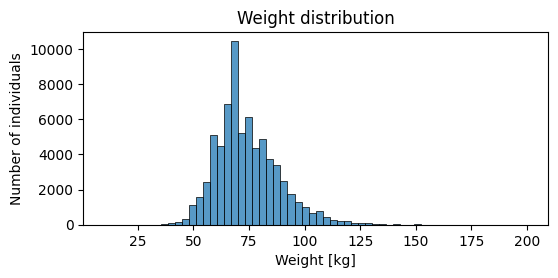

In [150]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.histplot(data=df, x='weight', bins=60), plt.title('Weight distribution'), plt.xlabel('Weight [kg]'), plt.ylabel('Number of individuals')
print(f"Weight Data [kg]: Mean={df['weight'].mean():.2f}, Stdev={df['weight'].std():.2f}, Min={df['weight'].min():.2f}, Max={df['weight'].max():.2f} ")

1f, length distribution:

Height Data [cm]: Mean=164.36, Stdev=8.21, Min=55.00, Max=250.00 


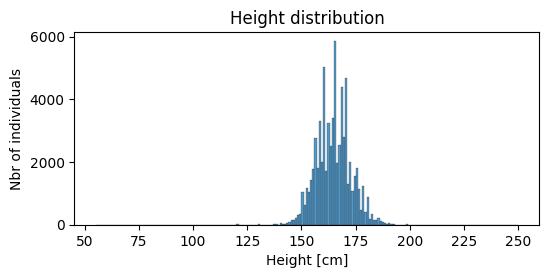

In [151]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.histplot(data=df, x='height', binwidth=1)
plt.title('Height distribution'), plt.xlabel('Height [cm]'), plt.ylabel('Nbr of individuals')
print(f"Height Data [cm]: Mean={df['height'].mean():.2f}, Stdev={df['height'].std():.2f}, Min={df['height'].min():.2f}, Max={df['height'].max():.2f} ")

1g: Ratio of cardivascular disease among men and women.

In [152]:
cardio_women = len(df[(df['gender'] == 1) & (df['cardio'] == 1)]) / len(df[(df['gender'] == 1)])
cardio_men = len(df[(df['gender'] == 2) & (df['cardio'] == 1)]) / len(df[(df['gender'] == 2)])
print(f'Cardiovascular disease among women = {cardio_women:.1%}, cardiovascular disease among men={cardio_men:.1%}')

Cardiovascular disease among women = 49.7%, cardiovascular disease among men=50.5%


ap_hi data [mmHg]: Mean=128.82, Stdev=154.01, Min=-150.00, Max=16020.00 
ap_lo data [mmHg]: Mean=96.63, Stdev=188.47, Min=-70.00, Max=11000.00 


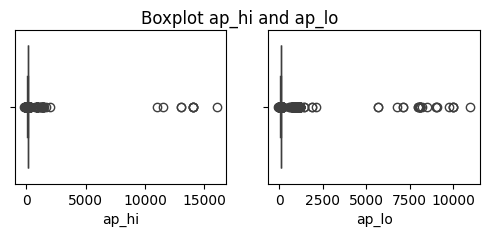

In [153]:
fig, ax = plt.subplots(1,2, figsize=(6,2))
plt.suptitle('Boxplot ap_hi and ap_lo')
sns.boxplot(data = df, x='ap_hi', ax=ax[0], orient='y')
sns.boxplot(data=df, x='ap_lo', ax=ax[1])
print(f"ap_hi data [mmHg]: Mean={df['ap_hi'].mean():.2f}, Stdev={df['ap_hi'].std():.2f}, Min={df['ap_hi'].min():.2f}, Max={df['ap_hi'].max():.2f} ")
print(f"ap_lo data [mmHg]: Mean={df['ap_lo'].mean():.2f}, Stdev={df['ap_lo'].std():.2f}, Min={df['ap_lo'].min():.2f}, Max={df['ap_lo'].max():.2f} ")

Correlation Matrix:

<Axes: >

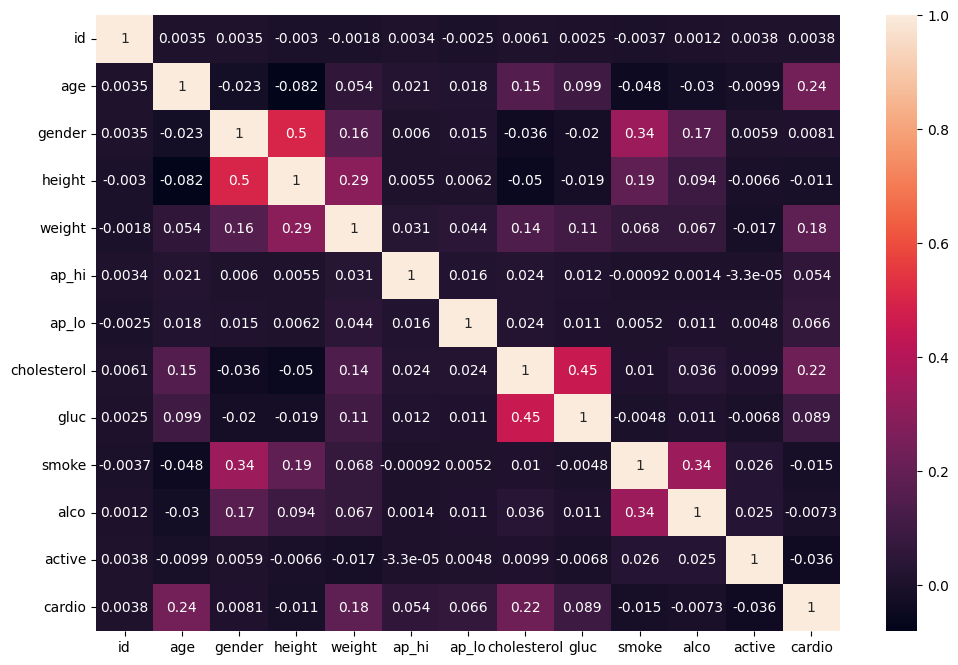

In [154]:
if 'age_yrs' in df.columns: df.drop(columns=['age_yrs'], inplace=True)
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_corr, annot=True)

In [155]:
# Listing top correlations between 'cardio' and the other features, in descending order.
a_corr = df_corr['cardio'].abs().sort_values(ascending=False)
print(a_corr[1:7])

age            0.238159
cholesterol    0.221147
weight         0.181660
gluc           0.089307
ap_lo          0.065719
ap_hi          0.054475
Name: cardio, dtype: float64


#### Summary of findings in EDA and correlation analysis:
- The data contains unrealistic values. E.g:
    - Weight data of 10kg, which is unrealistically low.
    - Height data of 55cm is unrealistically low. Height data of 250cm is probably also unrealistic, though possible.
    - Blood pressure data: there are unrealistic data that are either too low or even negative, as well as data that is way too high. The unit is mmHg, and my own basic knowledge is that values ranging from 60 to 140 is common among healthy individuals. High blood pressure is probably in the area of around 200+ mmHg.


- Original contains data that is unrealistic. An attempt has been made to removed the data that is unrealistic, but with a rather conservative approach in order to not remove valid data (probably there is still unrealistic data remaining). The removal of data has been done based on information found on internet (for blood pressure) and based on own experience (for weight and height). However, this can probably be fine tuned.
- Based on the correlation analysis, high blood pressure (ap_hi and ap_low) have the strongest correlation with 'cardio'. ap_hi and ap_lo are very much correlated as well (as expected).
- In descending order, the features with highest correlation to cardio are: api_hi, api_lo, age, cholesterol, weight and glucose.
- Height and gender is positvely correlated, meaning that men are taller than women.
- Smoking and gender is positively correlated (men are more prone to smoking).
- High glucose is not so correlated with cardio, but it is very mych correlated with cholesterol. Cholesterol in turn is relatively higly correlated with cardio.
- Weight and height have a positive correlation, meaning taller the individuals are generally heavier than short ones.
- The features gender, height, smoke, active and alco show very small correlation on cardio.
- Cardio is almost equally frequent among men and women.


### Feature engineering: Purpose is to handle the unrealistic data in the dataset.
#### Weight and Height
- Removing unrealistic data on weight and height, based on BMI. Involves the steps of calculating BMI for each individual. Theory from Wikipedia article used to define thresholds for removing data.
- Analysis of BMI in the dataset shows that BMI below the area of 14 is very "unlikely", they are very much outliers. At around BMI=14, the "bell curve" starts. Therefore, BMI<14 are removed.
- In the high end of BMI, the "bell curve" ends. There are very few values above that level. Values BMI>100 are removed. However, there is a slight risk that valid values are removed, for really obese individuals.

In [156]:
df['BMI'] = round(df['weight']/(df['height']/100)**2,2)

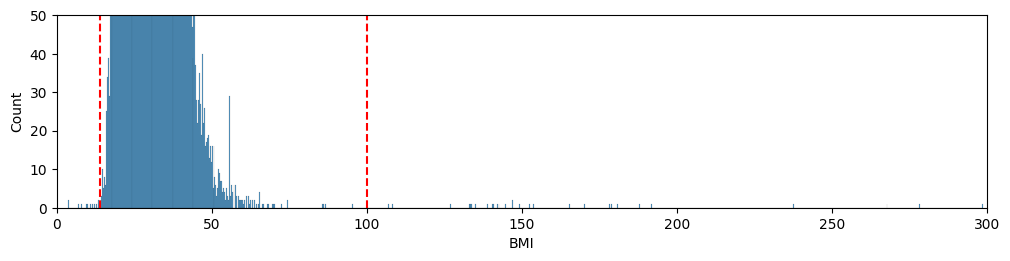

In [157]:
fig, ax = plt.subplots(figsize=(12,2.5))
sns.histplot(data=df, x='BMI', cumulative=False)
plt.xlim(right=300, left=0)
plt.ylim(top=50)
line_low = plt.Line2D(xdata=[14,14], ydata=[0,50], linestyle='--', color='red')
line_high = plt.Line2D(xdata=[100,100], ydata=[0,50], linestyle='--', color='red')
ax.add_line(line_low)
ax.add_line(line_high)

In [158]:
df = df[(df['BMI'] >= 14) & (df['BMI'] < 100)]

Weight Data [kg]: Mean=74.20, Stdev=14.35, Min=28.00, Max=200.00 


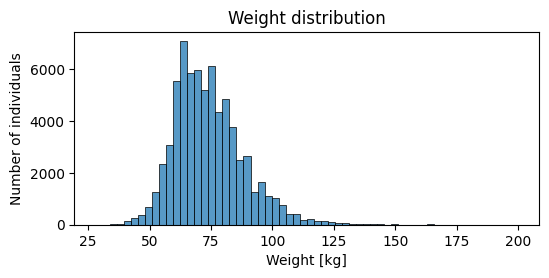

In [159]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.histplot(data=df, x='weight', bins=60), plt.title('Weight distribution'), plt.xlabel('Weight [kg]'), plt.ylabel('Number of individuals')
print(f"Weight Data [kg]: Mean={df['weight'].mean():.2f}, Stdev={df['weight'].std():.2f}, Min={df['weight'].min():.2f}, Max={df['weight'].max():.2f} ")

In [161]:
df[(df['weight']==28)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
34276,48976,14664,2,128,28.0,120,80,1,1,0,0,1,0,17.09


#### Blood Pressure
- Blood pressure is measured in mmHg. The article states that ap_hi below 120 and ap_lo below 80 is healthy. ap_hi above 180 and ap_lo above 120 is hypertension crisis. The scale ends there, not stating what max level is realistic. Analysis of the data, in combination with information from the article, indicates that a good approximation should be to keep values for (50 < ap_hi < 250) and (40 < ap_lo < 200). This approach removed 1280 instances from the dataset.

In [162]:
df = df[(df['ap_lo'] < 200) & (df['ap_lo'] > 40) & (df['ap_hi'] > 50) & (df_orig['ap_hi'] < 250)]
print(f'Removing unrealistic data (due to BMI and Blood Pressure) removed {len(df_orig)-len(df)} instances of the sampled data')

Removing unrealistic data (due to BMI and Blood Pressure) removed 1280 instances of the sampled data


C:\Users\danie\AppData\Local\Temp\ipykernel_20964\2521140880.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(df['ap_lo'] < 200) & (df['ap_lo'] > 40) & (df['ap_hi'] > 50) & (df_orig['ap_hi'] < 250)]


#### Creating categorical features on BMI and blood pressure.

In [163]:
df['BMI_class']=pd.cut(df['BMI'],bins=[0, 24.9, 29.9, 34.9, 39.9, 100], labels=['normal','overweight','obese class I','obese class II','obese class III'])
df['BP_class']=pd.cut(df['ap_hi'],bins=[0, 119.999, 129.99, 139.99, 179.99, 250], labels=['normal','elevated','high_stage_1','high_stage_2','high_crisis'])
df = pd.get_dummies(data= df, columns=['BMI_class','BP_class'], dtype=int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,BMI_class_normal,BMI_class_overweight,BMI_class_obese class I,BMI_class_obese class II,BMI_class_obese class III,BP_class_normal,BP_class_elevated,BP_class_high_stage_1,BP_class_high_stage_2,BP_class_high_crisis
0,0,18393,2,168,62.0,110,80,1,1,0,...,1,0,0,0,0,1,0,0,0,0
1,1,20228,1,156,85.0,140,90,3,1,0,...,0,0,0,1,0,0,0,0,1,0
2,2,18857,1,165,64.0,130,70,3,1,0,...,1,0,0,0,0,0,0,1,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,4,17474,1,156,56.0,100,60,1,1,0,...,1,0,0,0,0,1,0,0,0,0


<Axes: >

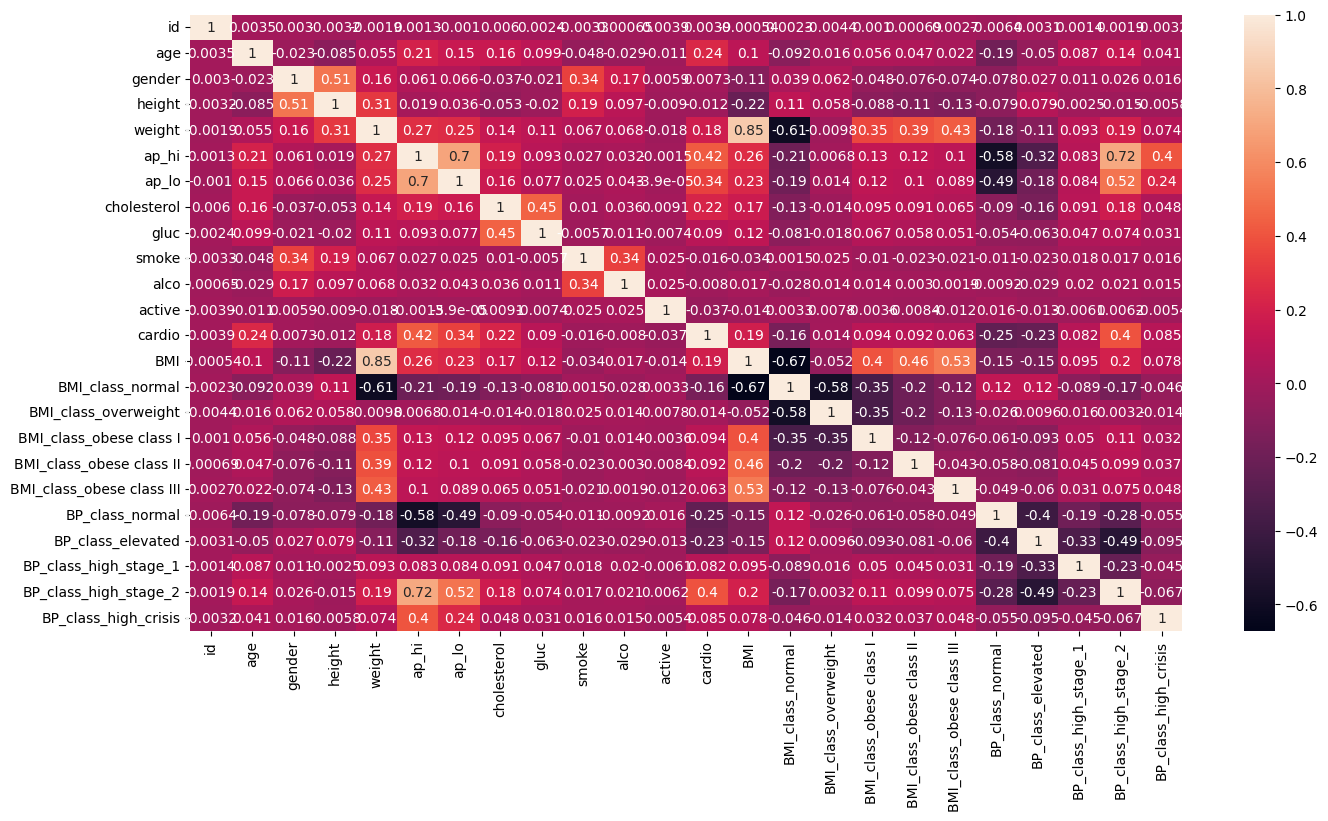

In [164]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(df.corr(), annot=True)

In [168]:
df_corr = df.corr()
a_corr = df_corr['cardio'].abs().sort_values(ascending=False)
print(a_corr)

cardio                       1.000000
ap_hi                        0.424984
BP_class_high_stage_2        0.399413
ap_lo                        0.335898
BP_class_normal              0.250154
age                          0.239604
BP_class_elevated            0.232047
cholesterol                  0.221455
BMI                          0.188373
weight                       0.180083
BMI_class_normal             0.155421
BMI_class_obese class I      0.094135
BMI_class_obese class II     0.091854
gluc                         0.090062
BP_class_high_crisis         0.084844
BP_class_high_stage_1        0.081512
BMI_class_obese class III    0.063340
active                       0.037474
smoke                        0.016234
BMI_class_overweight         0.013628
height                       0.012010
alco                         0.008025
gender                       0.007253
id                           0.003914
Name: cardio, dtype: float64


In [166]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,BMI_class_normal,BMI_class_overweight,BMI_class_obese class I,BMI_class_obese class II,BMI_class_obese class III,BP_class_normal,BP_class_elevated,BP_class_high_stage_1,BP_class_high_stage_2,BP_class_high_crisis
0,0,18393,2,168,62.0,110,80,1,1,0,...,1,0,0,0,0,1,0,0,0,0
1,1,20228,1,156,85.0,140,90,3,1,0,...,0,0,0,1,0,0,0,0,1,0
2,2,18857,1,165,64.0,130,70,3,1,0,...,1,0,0,0,0,0,0,1,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,4,17474,1,156,56.0,100,60,1,1,0,...,1,0,0,0,0,1,0,0,0,0


#### Conclusions feature engineering:
- BMI is correlated to Cardio (0.1883) but neither of the BMI classes are "exceeding" that. So the addition doesn't seem to aid much here.
- 

In [173]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'BMI',
       'BMI_class_normal', 'BMI_class_overweight', 'BMI_class_obese class I',
       'BMI_class_obese class II', 'BMI_class_obese class III',
       'BP_class_normal', 'BP_class_elevated', 'BP_class_high_stage_1',
       'BP_class_high_stage_2', 'BP_class_high_crisis'],
      dtype='object')

In [175]:
df1 = df.drop(columns=['ap_hi','ap_lo','height','weight','BMI'])
pd.get_dummies(df1, columns=['gender'], dtype=int)

df2 = df.drop(columns=['BMI_class_normal', 'BMI_class_overweight', 'BMI_class_obese class I',
       'BMI_class_obese class II', 'BMI_class_obese class III',
       'BP_class_normal', 'BP_class_elevated', 'BP_class_high_stage_1',
       'BP_class_high_stage_2', 'BP_class_high_crisis','height','weight'])
pd.get_dummies(df2, columns=['gender'], dtype=int)

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,gender_1,gender_2
0,0,18393,110,80,1,1,0,0,1,0,21.97,0,1
1,1,20228,140,90,3,1,0,0,1,1,34.93,1,0
2,2,18857,130,70,3,1,0,0,0,1,23.51,1,0
3,3,17623,150,100,1,1,0,0,1,1,28.71,0,1
4,4,17474,100,60,1,1,0,0,0,0,23.01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,120,80,1,1,1,0,1,0,26.93,0,1
69996,99995,22601,140,90,2,2,0,0,1,1,50.47,1,0
69997,99996,19066,180,90,3,1,0,1,0,1,31.35,0,1
69998,99998,22431,135,80,1,2,0,0,0,1,27.10,1,0
